In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sqlite3
from src.PairsTrading.PairsTradingEnvironment import PairsTradingEnvironment

from src.ResultService.VisualizationService import VisualizationService
from src.Benchmarking.Benchmarking import Benchmarking

In [2]:
pair = 
query = f'SELECT * FROM test_pairs WHERE pair = {pair} ORDER BY Date'
with sqlite3.connect('src/Data/pairs_trading.db') as conn:
    
    data = pd.read_sql(query, conn).drop(columns='pair')
data.Date.max()
test = data


In [3]:
pair = 0
query = f'SELECT * FROM training_pairs WHERE pair = {pair} ORDER BY Date'
with sqlite3.connect('src/Data/pairs_trading.db') as conn:
    
    data = pd.read_sql(query, conn).drop(columns='pair')
data.Date.max()
train = data

In [4]:
bb = Benchmarking(test)
bb.run_backtest_neat('src/Output/nets/trained_net_2023-07-06_09^%50^%59.pkl', 'src/Output/stats/training_stats_2023-07-06_09^%50^%59.pkl')
bb.run_backtest_linear()
bb.train_model_non_linear(train)
bb.run_back_test_non_linear()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


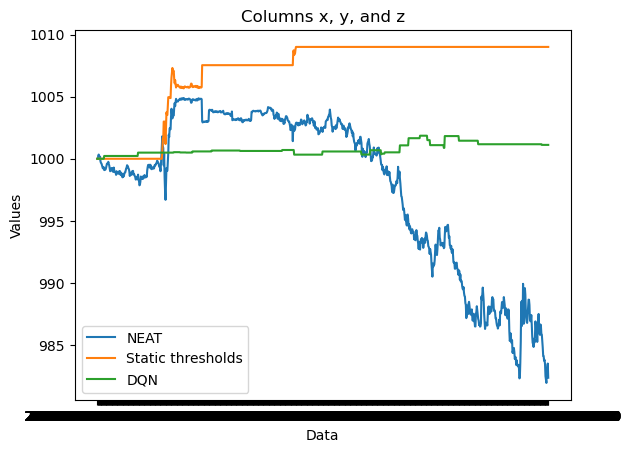

In [5]:
bb.plot_wealth_comparison()

In [8]:
wealth = bb.env_neat.portfolio.portfolio_info.merge(bb.env_linear.portfolio.portfolio_info, on='Date')[['Date', 'portfolio_value_x', 'portfolio_value_y']]
wealth = wealth.merge(bb.env_non_linear.portfolio.portfolio_info, on='Date')[['Date', 'portfolio_value_x', 'portfolio_value_y', 'portfolio_value']]


In [9]:
wealth.head()

,Date,portfolio_value_x,portfolio_value_y,portfolio_value
0,2019-08-23 00:00:00,1000.00,1000.0,1000.0
1,2019-08-26 00:00:00,999.75,1000.0,1000.0
2,2019-08-27 00:00:00,999.25,1000.0,1000.0
3,2019-08-28 00:00:00,999.00,1000.0,1000.0
4,2019-08-29 00:00:00,999.50,1000.0,1000.0


In [18]:
bb.env_non_linear.portfolio.portfolio_info.head()

,asset_1,price_asset_1,asset_2,price_asset_2,cash,portfolio_value,exposure,action,type,Date


In [9]:
## Make a stablebaselines PPO comparison run
import gym
import json
import datetime as dt

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN

# The algorithms require a vectorized environment to run
env = PairsTradingEnvironment(train, 100000)
#check_env(env)

model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=20000)

print('LEARNING COMPLETE, START TESTING')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 801      |
|    ep_rew_mean      | -0.00595 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 44       |
|    time_elapsed     | 72       |
|    total_timesteps  | 3204     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 801      |
|    ep_rew_mean      | 0.0117   |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 45       |
|    time_elapsed     | 140      |
|    total_timesteps  | 6408     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 801      |
|    ep_rew_mean      | 0.0161 

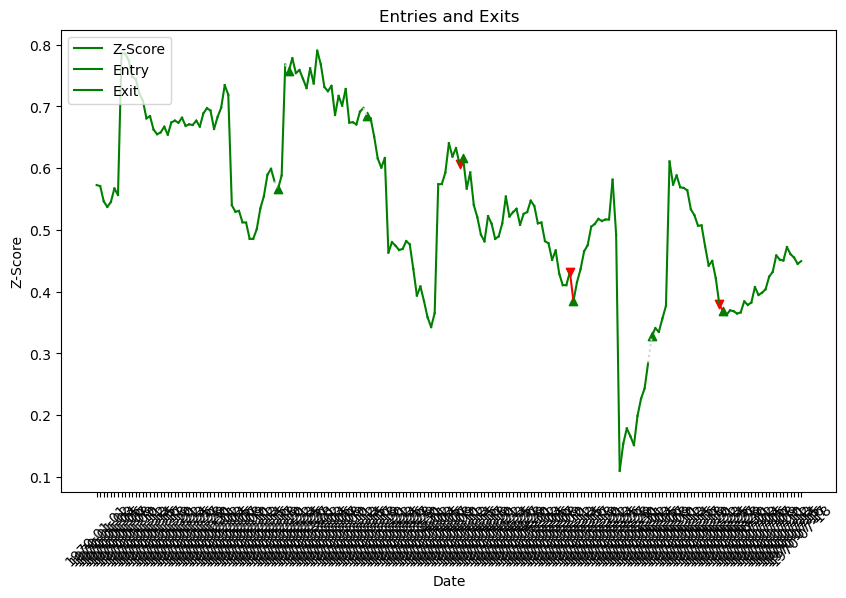

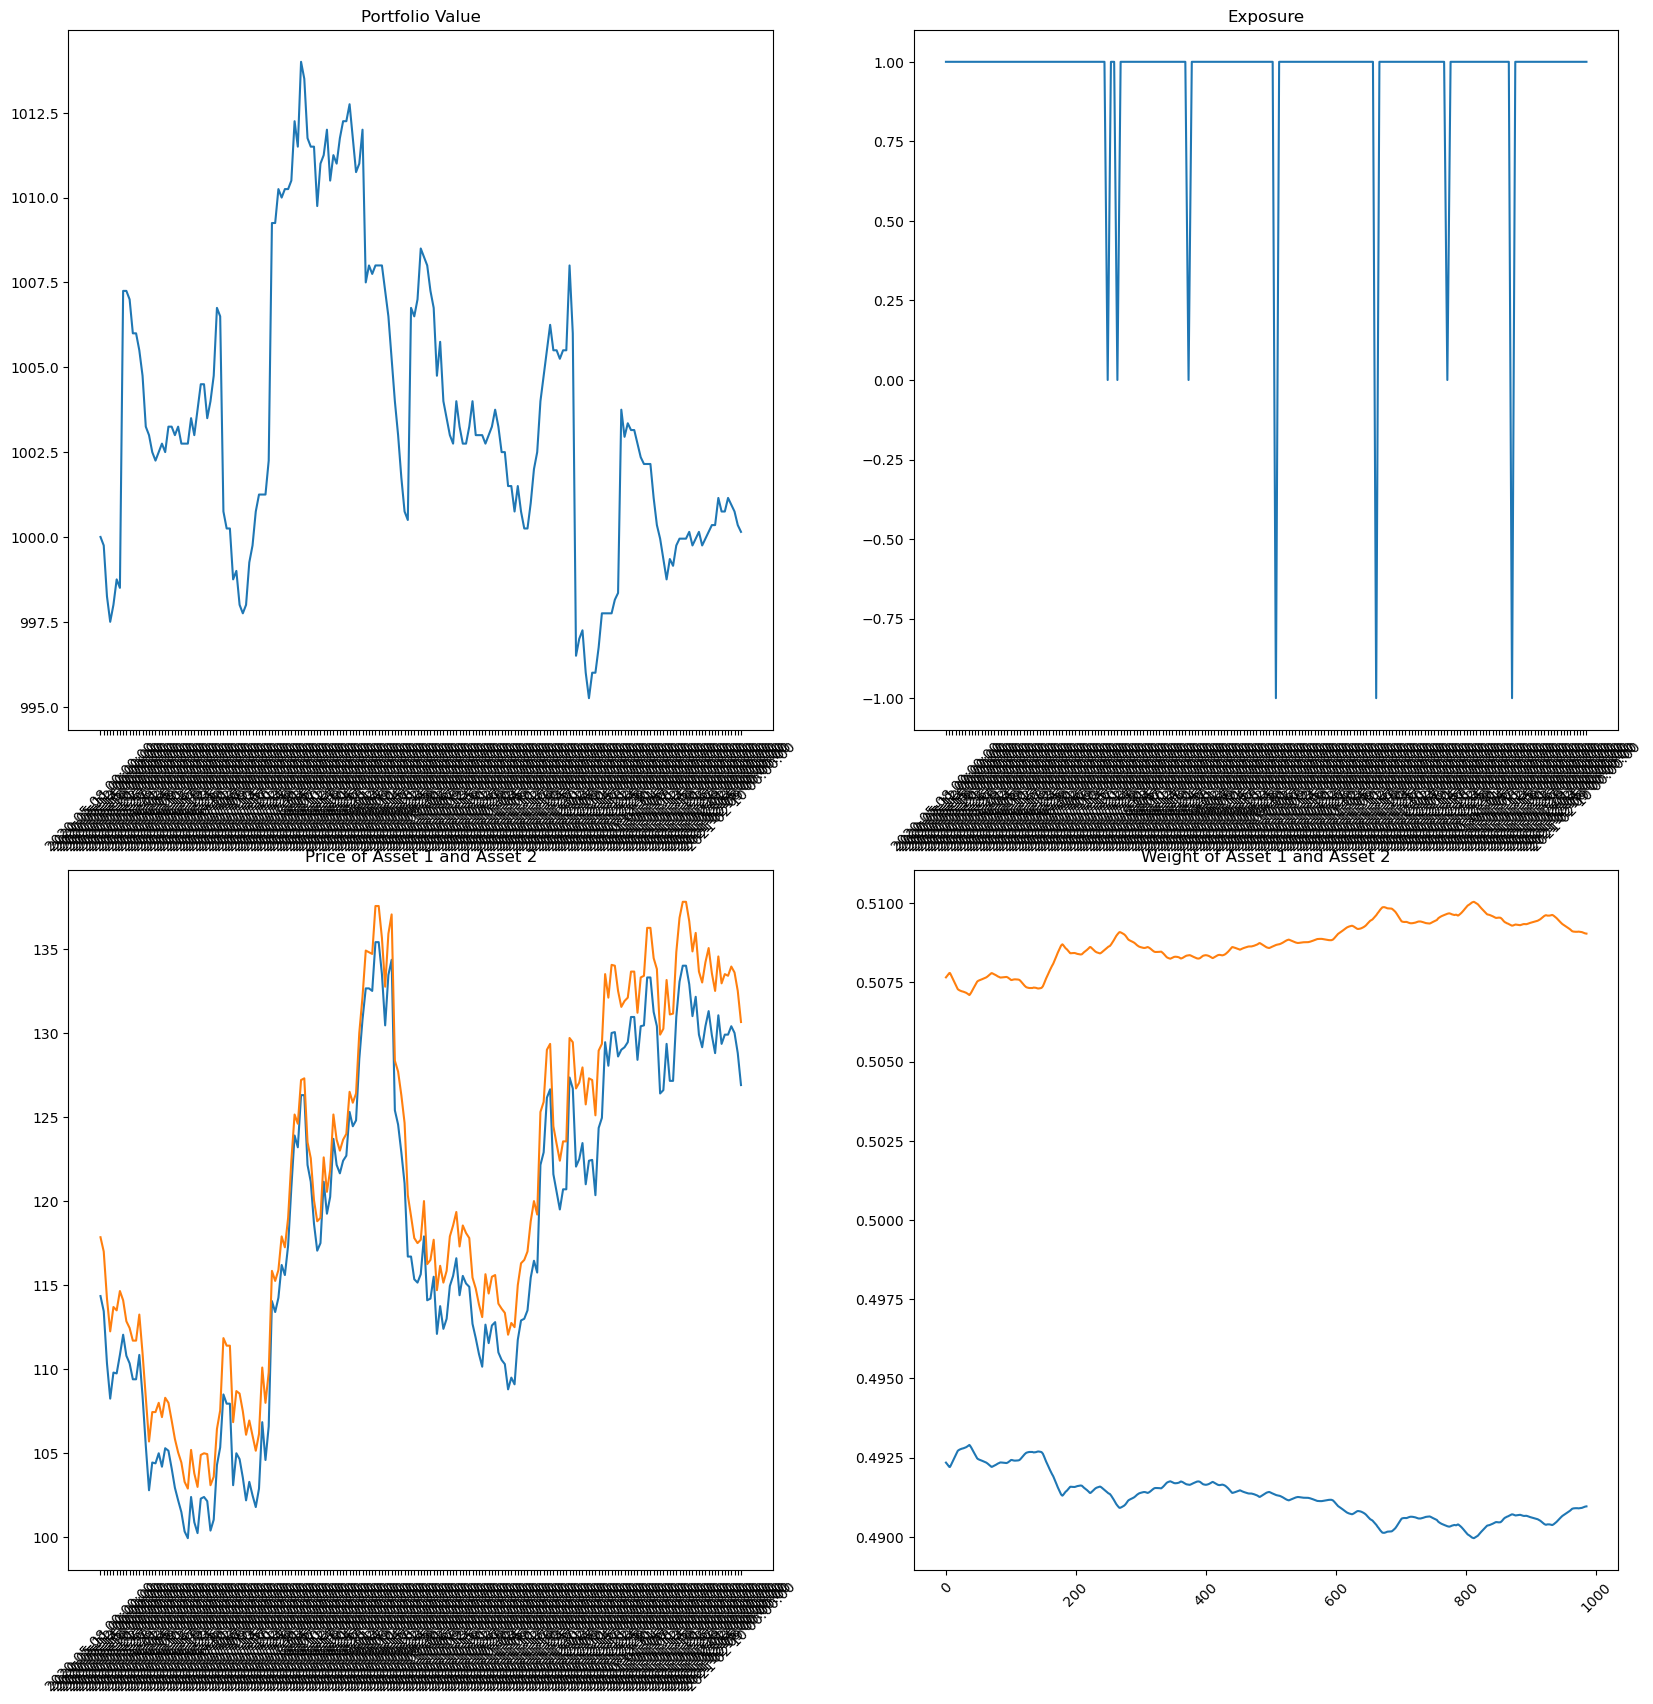

In [10]:
env_test = PairsTradingEnvironment(test, 1000)
obs = env_test.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env_test.step(action)
    if done:
        env_test.reset()
    env_test.render()
viz = VisualizationService(env_test.portfolio.get_portfolio_info(), test, env)
viz.plot_exposure_z_score()
viz.plot_portfolio_insights()

In [21]:
env_test.portfolio.portfolio_info.head()

,asset_1,price_asset_1,asset_2,price_asset_2,cash,portfolio_value,exposure,action,type,Date
0,4,130.15,-4,137.45,1029.2,1000.0,1,1,open,2015-12-07 00:00:00
1,4,129.30,-4,136.45,1029.2,1000.6,1,1,hold,2015-12-08 00:00:00
2,4,130.85,-4,137.75,1029.2,1001.6,1,1,hold,2015-12-09 00:00:00
3,4,130.35,-4,137.00,1029.2,1002.6,1,1,hold,2015-12-10 00:00:00
4,4,125.30,-4,132.30,1029.2,1001.2,1,1,hold,2015-12-11 00:00:00
